## Multistage Sampling Based on Predicted Control Yield
Dr. Jiehua Chen

jc3288@columbia.edu

### 1. Control Yield Prediction

In [87]:
library(rgdal)
library(raster)
library(gstat)
source("colMeans_new.R")
library(ggplot2)
library(rPython)

Loading required package: RJSONIO


#### 1.1 Load in data

All of the data are shared at
https://www.dropbox.com/s/soginipadvyggka/data.zip?dl=0

Please unzip this archive in the same folder that contains the code.

In [2]:
tamasa_data <- read.csv("data/maize_tamasa_2015.csv", stringsAsFactors=FALSE)
dryyield_perplot <- aggregate(cbind(tamasa_data$grain_dry_wt_subsample..g., tamasa_data$gps_longitude, tamasa_data$gps_latitude), by=list(tamasa_data$plotID), colMeans)
dryyield_perplot <- na.omit(dryyield_perplot)
names(dryyield_perplot) <- c("fieldID", "avg_dryweight", "longitude", "latitude")

#### 1.2 Extract remote sensing covariates
The spatial resolutions of those covariates are all 1km-by-1km
* CTI: Average compound topographic index;
* PH: predicted top soil PH from legacy data;
* SOC: predicted top soil SOC from legacy data;
* EVIA: Long-term average (2000–2014) average enhanced vegetation index;
* fPARs: Long-term average (2000–2014) fraction of absorbed photosynthetically active radiation;
* TMAPs: Long-term (1998–2013) mean annual precipitation;
* TMFIs: Long-term (1998–2013) average modified Fournier (rainfall aggressiveness) index. 

In [129]:
loc_laea <- project(cbind(dryyield_perplot$longitude, dryyield_perplot$latitude), "+proj=laea +ellps=WGS84 +lon_0=20 +lat_0=5 +units=m +no_defs")
tiffiles <- list.files("data/tif", pattern="tif", full.name=TRUE)
tiffiles

[1] "data/tif/CTIs.tif"                 "data/tif/depth.10.ph.mean.TZ.tif" 
[3] "data/tif/depth.10.soc.mean.TZ.tif" "data/tif/EVIAs.tif"               
[5] "data/tif/fPARs.tif"                "data/tif/TMAPs.tif"               
[7] "data/tif/TMFIs.tif"

In [7]:
remotesensing_files <- stack(tiffiles)
remotesensing_cov <- extract( remotesensing_files,loc_laea)
dryyield_perplot_withcov <- cbind(dryyield_perplot, remotesensing_cov)
names(dryyield_perplot_withcov)[6] <- "PH"
names(dryyield_perplot_withcov)[7] <- "SOC"
dryyield_perplot_withcov <- dryyield_perplot_withcov[, -c(1, 3, 4)]

str(dryyield_perplot_withcov)

#### 1.3 Estimate a linear model
The model does not fit so well due to the small size of the dataset. It might be worthwhile trying this with remote sensing covariates that have higher resolution.

In [100]:
lm_test <- lm(log(avg_dryweight)~., data=dryyield_perplot_withcov)

summary(lm_test)


Call:
lm(formula = log(avg_dryweight) ~ ., data = dryyield_perplot_withcov)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.80460 -0.26155  0.02691  0.36612  1.05987 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  5.784278   2.210464   2.617  0.01036 * 
CTIs        -0.197742   0.198562  -0.996  0.32190   
PH           0.103081   0.355709   0.290  0.77262   
SOC         -0.014498   0.007216  -2.009  0.04743 * 
EVIAs       -0.081187   0.271925  -0.299  0.76594   
fPARs        0.195978   0.282824   0.693  0.49008   
TMAPs        1.457691   0.492967   2.957  0.00394 **
TMFIs       -1.030458   0.349562  -2.948  0.00405 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5444 on 93 degrees of freedom
Multiple R-squared:  0.1377,	Adjusted R-squared:  0.07281 
F-statistic: 2.122 on 7 and 93 DF,  p-value: 0.0487


### 2. Control yield prediction

#### Extract prediction covariates using geosurvey cropland prediction mask

In [118]:
crp_map <- readGDAL("data/TZ_crp_ens_1k.tif")
coordinates_crplocs <- coordinates(crp_map)[!is.na(crp_map@data$band1), ]
crpdata <- crp_map@data$band1[!is.na(crp_map@data$band1)]
coordinates_crplocs <- coordinates_crplocs[crpdata>0.51, ]
predict_cov <- extract(remotesensing_files, coordinates_crplocs)

data/TZ_crp_ens_1k.tif has GDAL driver GTiff 
and has 1192 rows and 1211 columns


In [119]:
predict_cov <- as.data.frame(predict_cov)
names(predict_cov)[2] <- "PH"
names(predict_cov)[3] <- "SOC"

predicted_values <- predict(lm_test, predict_cov)

predicted_values_withcov <- data.frame(predicted_values = exp(predicted_values), x= coordinates_crplocs[,1], y=coordinates_crplocs[,2])
predicted_values_withcov <- na.omit(predicted_values_withcov)

coordinates(predicted_values_withcov)  =~x+y
predicted_values_withcov@proj4string@projargs <- " +proj=laea +lat_0=5 +lon_0=20 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs"

gridded(predicted_values_withcov) <- TRUE
writeGDAL (
  dataset=predicted_values_withcov["predicted_values"],
  fname="dryweight_predicted.tif",
  drivername= "GTiff",
  type="Float32")


Warning message:
In points2grid(points, tolerance, round): grid has empty column/rows in dimension 1Warning message:
In points2grid(points, tolerance, round): grid has empty column/rows in dimension 2

### Aggregate the prediction map to 10km-by-10km

In [125]:
GID <- function(location, res.pixel){
    xgid <- floor(location[,1]/res.pixel)
    ygid <- floor(location[,2]/res.pixel)
    gidx <- ifelse(location[,1]<0, paste("W", abs(xgid), sep=""), paste("E", abs(xgid), sep=""))
    gidy <- ifelse(location[,2]<0, paste("S", abs(ygid), sep=""), paste("N", abs(ygid), sep=""))
    GID <- paste(gidx, gidy, sep="-")
    return(list(xgid=xgid, ygid=ygid, GID=GID))
}


GID_10K <- GID(coordinates(predicted_values_withcov), 10000)
coords_GID10K <- data.frame(x = GID_10K[[1]]*10000, y=GID_10K[[2]]*10000, GID=GID_10K[[3]])

predicted_values_10K <- aggregate(predicted_values_withcov@data$predicted_values, by=list(coords_GID10K[,3]), mean)
GID_10K_coord <- aggregate(cbind(coords_GID10K$x, coords_GID10K$y), by=list(coords_GID10K[,3]), colMeans)
predicted_values_10K <- merge(predicted_values_10K, GID_10K_coord, by='Group.1')
str(predicted_values_10K)

'data.frame':	5539 obs. of  4 variables:
 $ Group.1: Factor w/ 5539 levels "E106-S108","E106-S109",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ x      : num  656 728 657 533 518 ...
 $ V1     : num  1060000 1060000 1060000 1070000 1070000 1070000 1070000 1070000 1070000 1080000 ...
 $ V2     : num  -1080000 -1090000 -1100000 -1050000 -1060000 -1070000 -1080000 -1090000 -1100000 -1040000 ...


#### k-means clustering for the control yield predictions on 10km-by-10km

In [126]:
kmeans_10K <- kmeans(predicted_values_10K$x,centers=5)
kmeans_10K$centers

1,955.3821
2,615.5766
3,1579.413
4,2382.925
5,411.7799


In [127]:
names(predicted_values_10K) <- c("GID_10K", "predicted_Values", "x", "y")
predicted_values_10K$predicted_10k_cat <- kmeans_10K$cluster
coordinates(predicted_values_10K)  =~x+y
predicted_values_10K@proj4string@projargs <- " +proj=laea +lat_0=5 +lon_0=20 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs"


gridded(predicted_values_10K) <- TRUE

writeGDAL (
  dataset=predicted_values_10K["predicted_10k_cat"],
  fname="dryweight_predicted_cat_10k.tif",
  drivername= "GTiff",
  type="Float32")

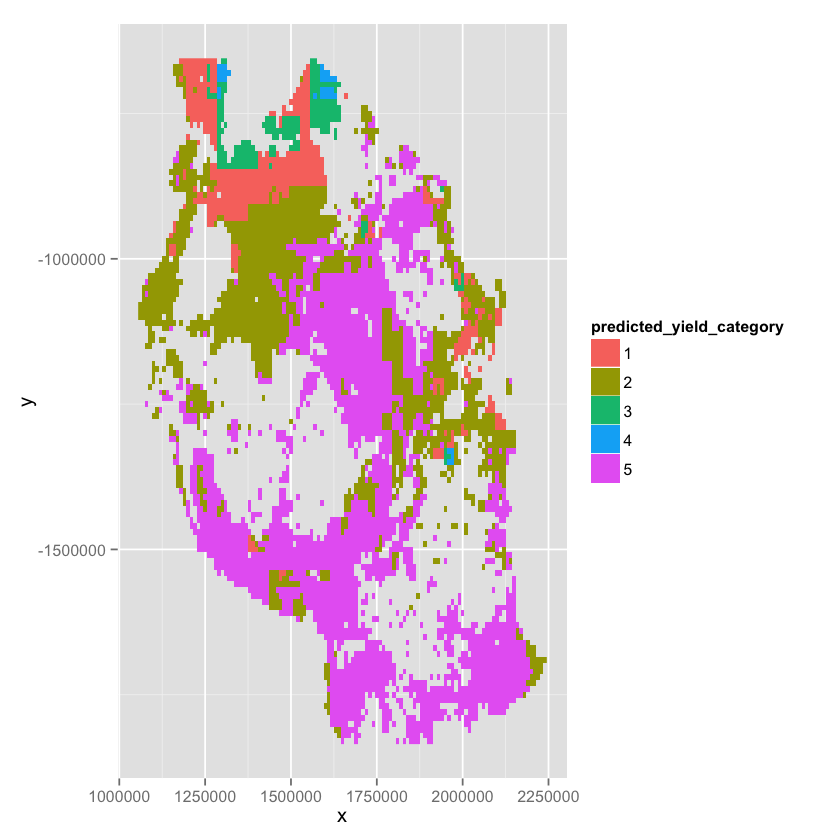

In [128]:
yield_map <- raster("dryweight_predicted_cat_10k.tif")
map.p <- rasterToPoints(yield_map)
df <- data.frame(map.p)
names(df) <- c("x", "y", "predicted_yield_category")
df$predicted_yield_category <- as.factor(df$predicted_yield_category)
ggplot(data=df, aes(y=y, x=x), color='green') + geom_raster(aes(fill=predicted_yield_category)) 

### Sampling Within 10km-by-10km Grid
When we decide locations for 10km-by-10km grids, we can implement multistage sampling to select locations. Here we can use different settings of upper and lower values of the predicted control yields to sample points in different categories. 

In [130]:
GID_10K_selected  <- "E129-S153"
predicted_values_selected_1k <- cbind(predicted_values_withcov@data$predicted_values, coordinates(predicted_values_withcov))[coords_GID10K[,3]==GID_10K_selected,]
xylocs = unique(coords_GID10K[coords_GID10K[,3]==GID_10K_selected, 1:2])

The following code can be executed as follows:

    python multistage_sampling.py [x] [y] [num_samples] [output_filename] [tif_control_filename] [upperrange] [lowerrange] [num_1k_in_each_5k]

where the inputs are:
* [x] and [y]: center locations of 10k by 10k grid, using the following PROJ4 string: " +proj=laea +lat_0=5 +lon_0=20 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs" 
* [num_samples]: number of samples within each 1k by 1k, 
* [output_filename]: name_name of the output file, 
* [tif_control_filename]: tif file name of the 1k by 1k control yield prediction map, 
* [upperrange] [lowerrange]: only 1k by 1k cells with with values between the [upperrange] and [lowerrange] will be sampled, 
* [num_1k_in_each_5k]: number of 1k by 1k grids to be sampled within each 5k by 5k

Example:

    python multistage_sampling.py 1290000 -1530000 1 E129-S153 dryweight_predicted.tif 1000 300 4



In [95]:
system(paste('python multistage_sampling.py', xylocs[1], xylocs[2], 1, GID_10K_selected, "dryweight_predicted.tif", 1000, 0, 4)) 